## Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
from matplotlib import colormaps as cm
from scipy import ndimage
import matplotlib.gridspec as gridspec
import os
!pip install s3fs
import warnings
warnings.filterwarnings('ignore')
import s3fs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 37.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Downloading Datasets:


In [3]:
def download_files(number_of_files, download_dir):
    '''
    Will download a specified number of files to the download directory unless the maximum attempts is reached.
    '''
    product = 'ABI-L2-MCMIPC'
    satellite = 'goes16'

    # Check filepath:
    if not os.path.isdir(download_dir):
        os.makedirs(download_dir)

    # Set number of files, max attempts, and current attempts. This will stop the script early if necessary.

    num_files = 0
    max_attempts = 100
    attempts = 0

    fs = s3fs.S3FileSystem(anon= True)

    while num_files < number_of_files and attempts < max_attempts:
        attempts += 1

        # Select random year, day, hour:
        year = np.random.randint(low= 2018, high= 2024)
        day = np.random.randint(low= 1, high= 366)
        hour= np.random.randint(low= 0, high= 23)

        s3_path = f'noaa-{satellite}/{product}/{year}/{day}/{hour}/'

        try:

            files = fs.ls(s3_path)
            if not files:
                continue

            # Choose random file out of the available ones for the given hour. This helps avoid getting similar images from the same storm at different time steps.
            file_to_download = np.random.choice(files)
            s3_file_path = f's3://{file_to_download}'
            local_file_path = os.path.join(download_dir, os.path.basename(file_to_download))

            print(f'Downloading {file_to_download}...')
            fs.get(s3_file_path, local_file_path)
            print('Success!')


            num_files = len(next(os.walk(download_dir))[2])

        except Exception as e:
            print(f'Failed to download from {s3_path}: {e}')
            continue

        if attempts >= max_attempts:
            print("Max attempts reached. Ending download.")

    print(f'Download complete: {num_files} files in {download_dir}')

# Time to download!

In [4]:
# download_dir = '/content/drive/MyDrive/CCM/Datasets'
# download_files(150)

In [5]:
cmap = cm['gist_ncar_r'].copy() # Colormap for images
cmap.set_bad(color='gray') # Setting any missing/nan values to gray to make it look nice
vmin = 200
vmax = 320

In [6]:
def clean_CMI(CMI):
  '''
  Hides anything above 270 Kelvin. Then filters out any features that are too small.Returns a list of cleaned features.
  '''
  temperature_mask = CMI.where(CMI.data <= 270) # Masking any data points over 270 Kelvin. This should isolate any important cloud features.

  mask = CMI.data < 270 # Mask that works with scipy ```label``` function. This creates an array of True/False values.

  labeled_array, num_features = ndimage.label(mask) # Returns ```labeled_array```, which returns the array with each unique feature labeled with a different number.
  # Also returns ```num_features```, which is the number of unique features found.
  region_sizes = ndimage.sum_labels(mask, labeled_array, range(1, num_features + 1)) # Calculates the sum, or in this case, the "area", of each unique feature.

  min_size = 5000 # Arbitrarily chosen minimum size
  region_mask = np.zeros_like(mask, dtype= bool) # Array with the same shape as our original array but with all Falses. This will be iterated over in order to flip needed values to True.

  for i, size in enumerate(region_sizes): # Loop through region sizes while keeping track of the index. If the feature is larger than the minimum size, ```region_mask```
          if size >= min_size:            # is updated to True.
              region_mask = region_mask | (labeled_array == (i + 1))

  cleaned_CMI = CMI.where(region_mask) # recreating our mask from before, now with only the large important features.

  filtered_labels, new_features = ndimage.label(region_mask) # Labeling unique features within our new filtered mask, similar to before.
  features = [] # Creates an empty list that each unique feature will be stored in.

  for label in range(1, new_features + 1):  # Iterating through the number of unique features found.
      feature_mask = filtered_labels == label # Creating a temporary array of True/False where only the feature with the number associated with ```label``` is labeled as "True".

      CMI_feature = CMI.where(feature_mask)  # Creates temporary mask that only lets the unique feature show.

      coords = np.argwhere(feature_mask) # Finds indicies of our feature.
      ymin, xmin = coords.min(axis= 0) # Gives the minimum x and y values.
      ymax, xmax = coords.max(axis= 0) + 1 # Gives the maximum x and y values.

      cropped = CMI_feature.isel(y= slice(ymin, ymax), x= slice(xmin, xmax)) # Slicing into dataarray with our x and y coordinates in order to isolate them.
      features.append(cropped) # Feature is added to our list.

  return features

In [7]:
def resize_features(features, shape):
  '''
  Takes a list of features and resizes them to a given dimension.
  '''
  resized_features = []

  for feature in features:
      data = feature.data

      # Filters out any blank images
      if np.all(np.isnan(data)):
          continue

      # Turns any null values to 0.0, then uses ndimage to resize.
      filled_data = np.nan_to_num(data)
      zoom = (shape / filled_data.shape[0], shape / filled_data.shape[1])
      resized_data = ndimage.zoom(filled_data, zoom, order= 1)

      resized_features.append(resized_data)

  return resized_features

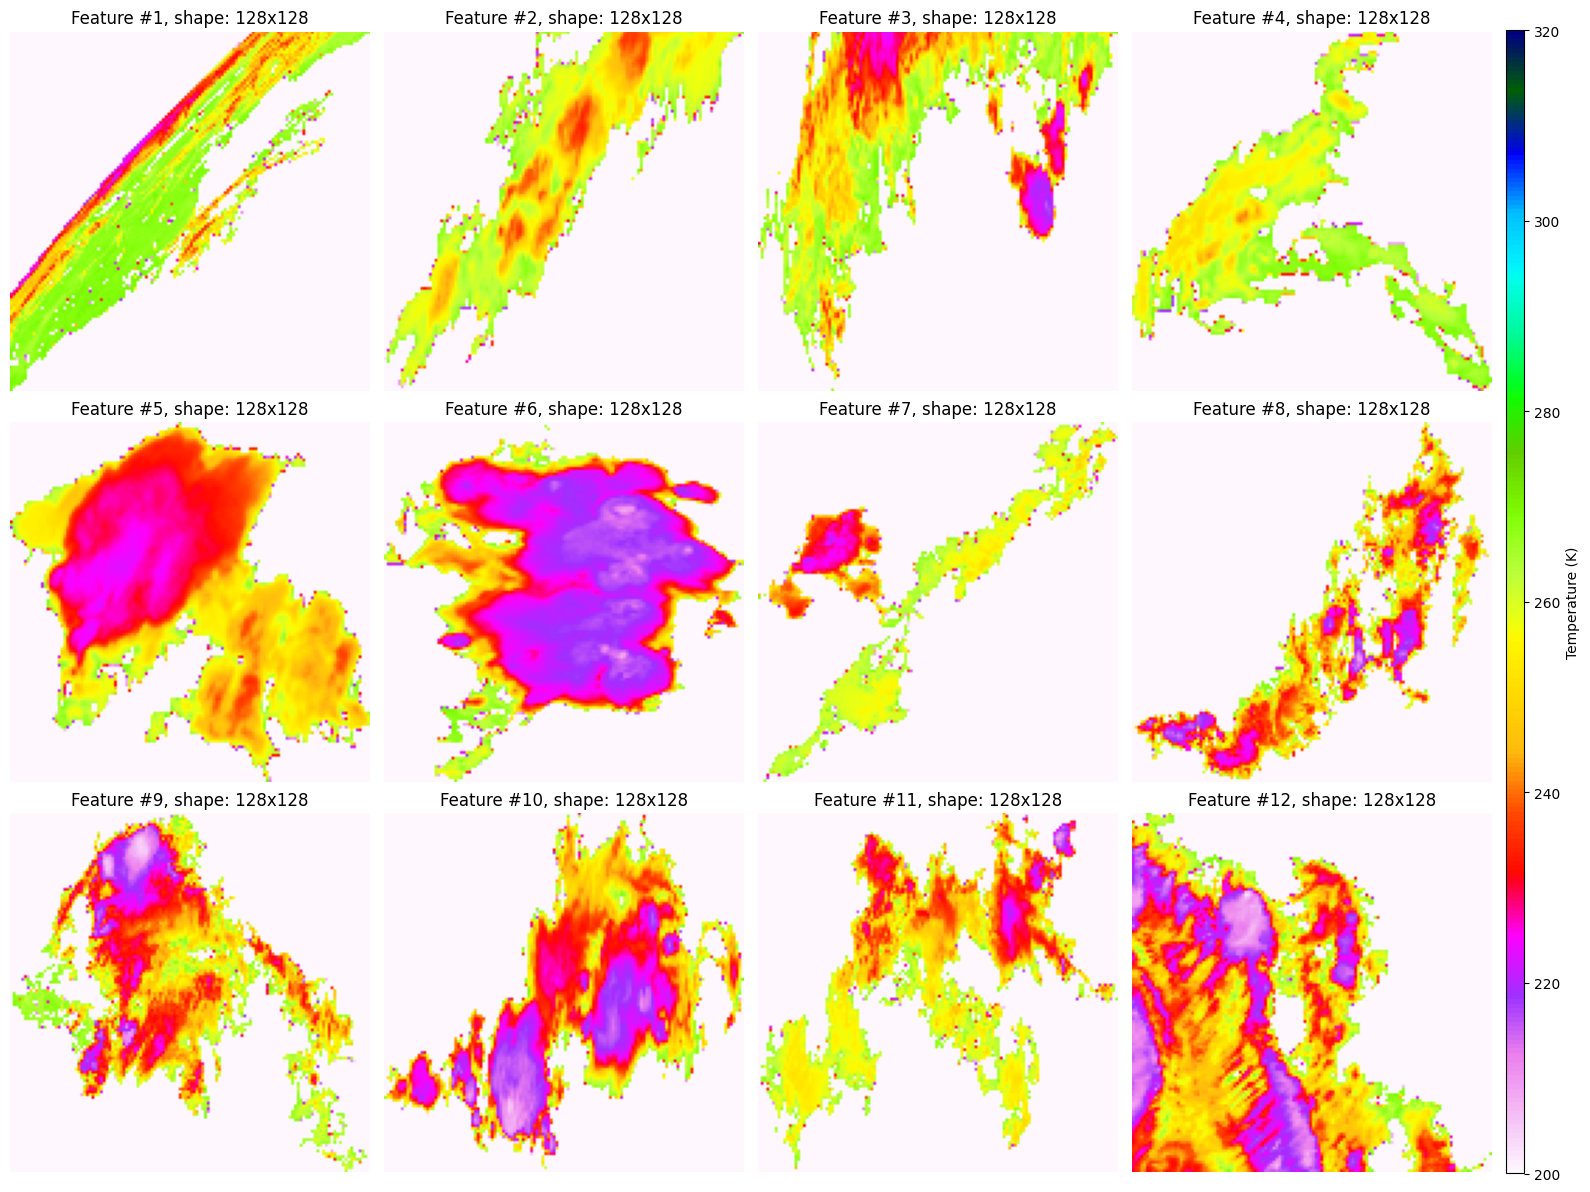

In [11]:
# Let's view each individual feature. These subplots need to be dynamic, so we must do some math to determine the needed number of columns and rows.
dataset_temp = xr.open_dataset('/content/drive/MyDrive/CCM/Datasets/OR_ABI-L2-MCMIPC-M6_G16_s20232501831171_e20232501833556_c20232501834065.nc')
features = clean_CMI(dataset_temp['CMI_C13'])

n = len(features) # Number of features in our feature list. This is the number of plots needed. The shape of the subplots is rectangular, so we will need to determine rows and columns.
ncols = int(np.ceil(np.sqrt(n))) # Assume the shape is a square and take the square root to determine columns.
nrows = int(np.ceil(n / ncols)) # Take n, our "area", and divide by columns to get number of rows. ```np.ceil``` is used to round up to ensure an adequate number of subplots are created.

shape = 128

resized_features = resize_features(features, shape= shape)

fig = plt.figure(figsize= (4 * ncols, 4 * nrows))
gs = gridspec.GridSpec(nrows, ncols + 1, width_ratios= [1]* ncols + [0.05])
axes = [fig.add_subplot(gs[i // ncols, i % ncols]) for i in range(n)]

for i, feature in enumerate(resized_features):
    im = axes[i].imshow(feature, cmap= cmap, vmin= vmin, vmax= vmax)
    axes[i].set_title(f'Feature #{i+1}, shape: {shape}x{shape}')
    axes[i].axis('off')

cax = fig.add_subplot(gs[:, -1])
fig.colorbar(im, cax=cax, label= 'Temperature (K)')

plt.tight_layout()
plt.show()

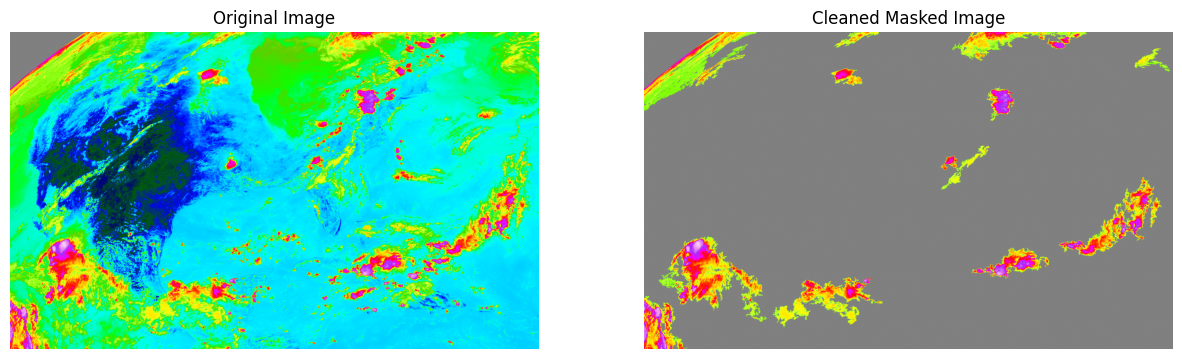

In [13]:
CMI = dataset_temp['CMI_C13']
temperature_mask = CMI.where(CMI.data <= 270) # Masking any data points over 270 Kelvin. This should isolate any important cloud features.

mask = CMI.data < 270 # Mask that works with scipy ```label``` function. This creates an array of True/False values.

labeled_array, num_features = ndimage.label(mask) # Returns ```labeled_array```, which returns the array with each unique feature labeled with a different number.
# Also returns ```num_features```, which is the number of unique features found.
region_sizes = ndimage.sum_labels(mask, labeled_array, range(1, num_features + 1)) # Calculates the sum, or in this case, the "area", of each unique feature.

min_size = 5000 # Arbitrarily chosen minimum size
region_mask = np.zeros_like(mask, dtype= bool) # Array with the same shape as our original array but with all Falses. This will be iterated over in order to flip needed values to True.

for i, size in enumerate(region_sizes): # Loop through region sizes while keeping track of the index. If the feature is larger than the minimum size, ```region_mask```
        if size >= min_size:            # is updated to True.
            region_mask = region_mask | (labeled_array == (i + 1))

cleaned_CMI = CMI.where(region_mask) # recreating our mask from before, now with only the large important features.
fig, ax = plt.subplots(nrows= 1, ncols= 2, figsize = (15, 10))
ax = ax.flatten()


im = ax[0].imshow(CMI, cmap= cmap, vmin= vmin, vmax= vmax)
ax[1].imshow(cleaned_CMI, cmap= cmap, vmin= vmin, vmax= vmax)
ax[0].axis('off')
ax[1].axis('off')
ax[0].set_title('Original Image')
ax[1].set_title('Cleaned Masked Image')

plt.show()

# Loop!


In [ ]:
def save_features(download_dir, output_folder):
  '''
  Opens each netCDF and saves each feature as a PNG.
  '''
  cmap = cm['gist_ncar_r'].copy() # Colormap
  cmap.set_bad(color='gray') # Setting any missing/nan values to gray to make it look nice


  files = next(os.walk(download_dir))[2]

  for file in files:

    dataset = xr.open_dataset(f'{download_dir}{file}')

    CMI = dataset['CMI_C13']

    features = clean_CMI(CMI)
    resized_features = resize_features(features, 128)

    for i, image in enumerate(resized_features):
      plt.imsave(os.path.join(output_folder, f"{file}_feature_{i+1:02d}.png"), image, cmap=cmap, vmin=vmin, vmax=vmax)
      print(f'{file}_feature_{i+1:02d}.png saved successfully')
    print('All done!')



# Downloading an exra test dataset:

In [ ]:
download_dir = '/content/drive/MyDrive/CCM/Test_Datasets/'
output_folder = '/content/drive/MyDrive/CCM/Test_Extracted_Cloud_Features/'


# download_files(50, download_dir)
# save_features(download_dir, output_folder)